# Random Sampling of Rewrites

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import json
# import random
# import os
# import re

# def create_latex_tables_from_samples(file_paths, num_samples=10, max_text_length=100):
#     def load_json_lines(file_path):
#         with open(file_path, 'r') as file:
#             return [json.loads(line) for line in file]

#     def find_armo_rm_key(item):
#         return next((key for key in item.keys() if 'ArmoRM' in key), None)

#     def truncate_text(text, max_length):
#         return text[:max_length] + '...' if len(text) > max_length else text

#     def escape_latex(text):
#         latex_special_chars = {'&': r'\&', '%': r'\%', '$': r'\$', '#': r'\#', '_': r'\_', '{': r'\{', '}': r'\}', '~': r'\textasciitilde{}', '^': r'\^{}', '\\': r'\textbackslash{}'}
#         return ''.join(latex_special_chars.get(c, c) for c in text)

#     def format_reward(reward):
#         return f"{reward:.5f}" if isinstance(reward, (int, float)) else reward

#     def get_descriptive_title(file_name):
#         # Extract database and concept from file name
#         match = re.match(r'(\w+)_(\w+)_', file_name)
#         if match:
#             database, concept = match.groups()
#             database = database.upper() if database.lower() == 'eli5' else database.capitalize()
#             return f"{database}, {concept.capitalize()}"
#         return file_name  # Fallback to filename if pattern doesn't match

#     def create_table(data, file_name):
#         title = get_descriptive_title(file_name)
#         latex_table = f"\\subsection*{{{title}}}\n"
#         latex_table += r"\begin{tabular}{|p{0.22\textwidth}|p{0.22\textwidth}|p{0.22\textwidth}|p{0.22\textwidth}|}\hline" + "\n"
#         latex_table += r"Original & Rewrite & Rewrite of Rewrite & Reward \\ \hline" + "\n"

#         for item in data:
#             w_original = item.get('w_original', False)
#             original = escape_latex(truncate_text(item['completions'].get('original', 'N/A'), max_text_length))
#             rewrite = escape_latex(truncate_text(item['completions'].get('rewrite', 'N/A'), max_text_length))
#             rewrite_of_rewrite = escape_latex(truncate_text(item['completions'].get('rewritten rewrite', 'N/A'), max_text_length))
            
#             armo_rm_key = find_armo_rm_key(item)
#             if armo_rm_key:
#                 reward_original = format_reward(item[armo_rm_key].get('original', 'N/A'))
#                 reward_rewrite = format_reward(item[armo_rm_key].get('rewrite', 'N/A'))
#                 reward_rewrite_of_rewrite = format_reward(item[armo_rm_key].get('rewritten rewrite', 'N/A'))
#             else:
#                 reward_original = reward_rewrite = reward_rewrite_of_rewrite = 'N/A'

#             latex_table += f"{original} (W = {1 if w_original else 0}) & "
#             latex_table += f"{rewrite} (W = {0 if w_original else 1}) & "
#             latex_table += f"{rewrite_of_rewrite} & "
#             latex_table += f"({reward_original}, {reward_rewrite}, {reward_rewrite_of_rewrite}) \\\\ \\hline\n"

#         latex_table += r"\end{tabular}" + "\n\n"
#         return latex_table

#     all_tables = []
#     for file_path in file_paths:
#         data = load_json_lines(file_path)
#         samples = random.sample(data, num_samples)
#         file_name = os.path.basename(file_path)
#         table = create_table(samples, file_name)
#         all_tables.append(table)

#     return '\n'.join(all_tables)

# # Example usage:
# file_paths = [
#     "eli5_length_complete_scored_20240919_170111.jsonl",
#     "hh_rlhf_sentiment_scored_complete.jsonl",
#     "imdb_sentiment_complete_scored_20240919_152739.jsonl",
#     "helpsteer_complexity_complete_scored.jsonl",
#     "helpsteer_helpfulness_complete_scored.jsonl"
# ]

# # latex_tables = create_latex_tables_from_samples(file_paths, max_text_length=100)
# # print(latex_tables)

# Plotting Functions

In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from constants import SCORED_DIR
from treatment_effects import calculate_treatment_effects
from utils_plotting import naive_vs_RATE, att_atu, synthetic_subplots
from utils import load_dataset_from_json, write_to_json
import warnings
warnings.filterwarnings('ignore')

The first step is to define a list of dictionaries, each of which corresponds to a particular (dataset, concept, model) combination.

In [4]:
experiment_templates = [
    {
        "dataset_name": "ELI5",
        "concept": "Length",
        "score": "ArmoRM",
        "reward_key": "ArmoRM",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    },
    {
        "dataset_name": "ELI5",
        "concept": "Length",
        "score": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "reward_key": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    },
    {
        "dataset_name": "ELI5",
        "concept": "Length",
        "score": "FsfairX-LLaMA3-RM-v0.1",
        "reward_key": "sfairXC/FsfairX-LLaMA3-RM-v0.1",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Sentiment",
        "score": "ArmoRM",
        "reward_key": "ArmoRM",
        "dataset_filename": "imdb_sentiment_complete_scored_20240919_152739.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Sentiment",
        "score": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "reward_key": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "dataset_filename": "imdb_sentiment_complete_scored_20240919_152739.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Sentiment",
        "score": "FsfairX-LLaMA3-RM-v0.1",
        "reward_key": "sfairXC/FsfairX-LLaMA3-RM-v0.1",
        "dataset_filename": "imdb_sentiment_complete_scored_20240919_152739.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Complexity",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "helpsteer_complexity_complete_scored.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Complexity",
        "score": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "reward_key": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "dataset_filename": "helpsteer_complexity_complete_scored.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Complexity",
        "score": "FsfairX-LLaMA3-RM-v0.1",
        "reward_key": "sfairXC/FsfairX-LLaMA3-RM-v0.1",
        "dataset_filename": "helpsteer_complexity_complete_scored.jsonl"
    },        
    {
        "dataset_name": "HelpSteer",
        "concept": "Helpfulness",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "helpsteer_helpfulness_complete_scored.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Helpfulness",
        "score": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "reward_key": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "dataset_filename": "helpsteer_helpfulness_complete_scored.jsonl"
    },
    {
        "dataset_name": "HelpSteer",
        "concept": "Helpfulness",
        "score": "FsfairX-LLaMA3-RM-v0.1",
        "reward_key": "sfairXC/FsfairX-LLaMA3-RM-v0.1",
        "dataset_filename": "helpsteer_helpfulness_complete_scored.jsonl"
    },
    {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
    },
    {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        "score": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "reward_key": "NCSOFT/Llama-3-OffsetBias-RM-8B",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
    },
    {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        "score": "FsfairX-LLaMA3-RM-v0.1",
        "reward_key": "sfairXC/FsfairX-LLaMA3-RM-v0.1",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl",
        "original": "rewritten rewrite",
        "rewrite": "rewrite"
    }
]

Next we calculate the treatment effect data for each of these combinations.

In [5]:
# save all the data
effects_data = []
for effects_template in experiment_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "complete" / dataset_filename)
    effects = calculate_treatment_effects(dataset, **effects_template)
    effects_data.append(effects)

2024-10-02 00:08:17,063 - INFO - Number of w=1 examples: 12612
2024-10-02 00:08:17,063 - INFO - Number of w=0 examples: 12389
2024-10-02 00:08:17,112 - INFO - Treatment effects: {   'ATE': -0.0008267120345947232,
    'ATE_naive': 0.001494292597008548,
    'ATE_stderr': 6.802260984332354e-05,
    'ATE_stderr_naive': 9.391197021986063e-05,
    'ATT': 0.0005248629986794456,
    'ATT_naive': -0.002639021079802975,
    'ATT_stderr': 0.0003215778627196273,
    'ATT_stderr_naive': 0.000316398091089196,
    'ATU': -0.002202615200278285,
    'ATU_naive': 0.00570200525274725,
    'ATU_stderr': 0.0003354240091955926,
    'ATU_stderr_naive': 0.0003233334507112074,
    'naive_effect': 0.0033786455857264808,
    'naive_effect_naive': 0.008119381960269595,
    'naive_effect_stderr': 0.0003303620560513964,
    'naive_effect_stderr_naive': 0.0003128414498368806}
2024-10-02 00:08:17,113 - INFO - Calculated ATE (from ATT and ATU): -0.0008267120345947166
2024-10-02 00:08:17,126 - INFO - Rewrite effects: {

To compare the naive vs RATE estimates, we create a list of reward models we are interested in testing, then feed in this list along with the calculated treatment effect data and the original template. We normalize the treatment effect data and plot the results.

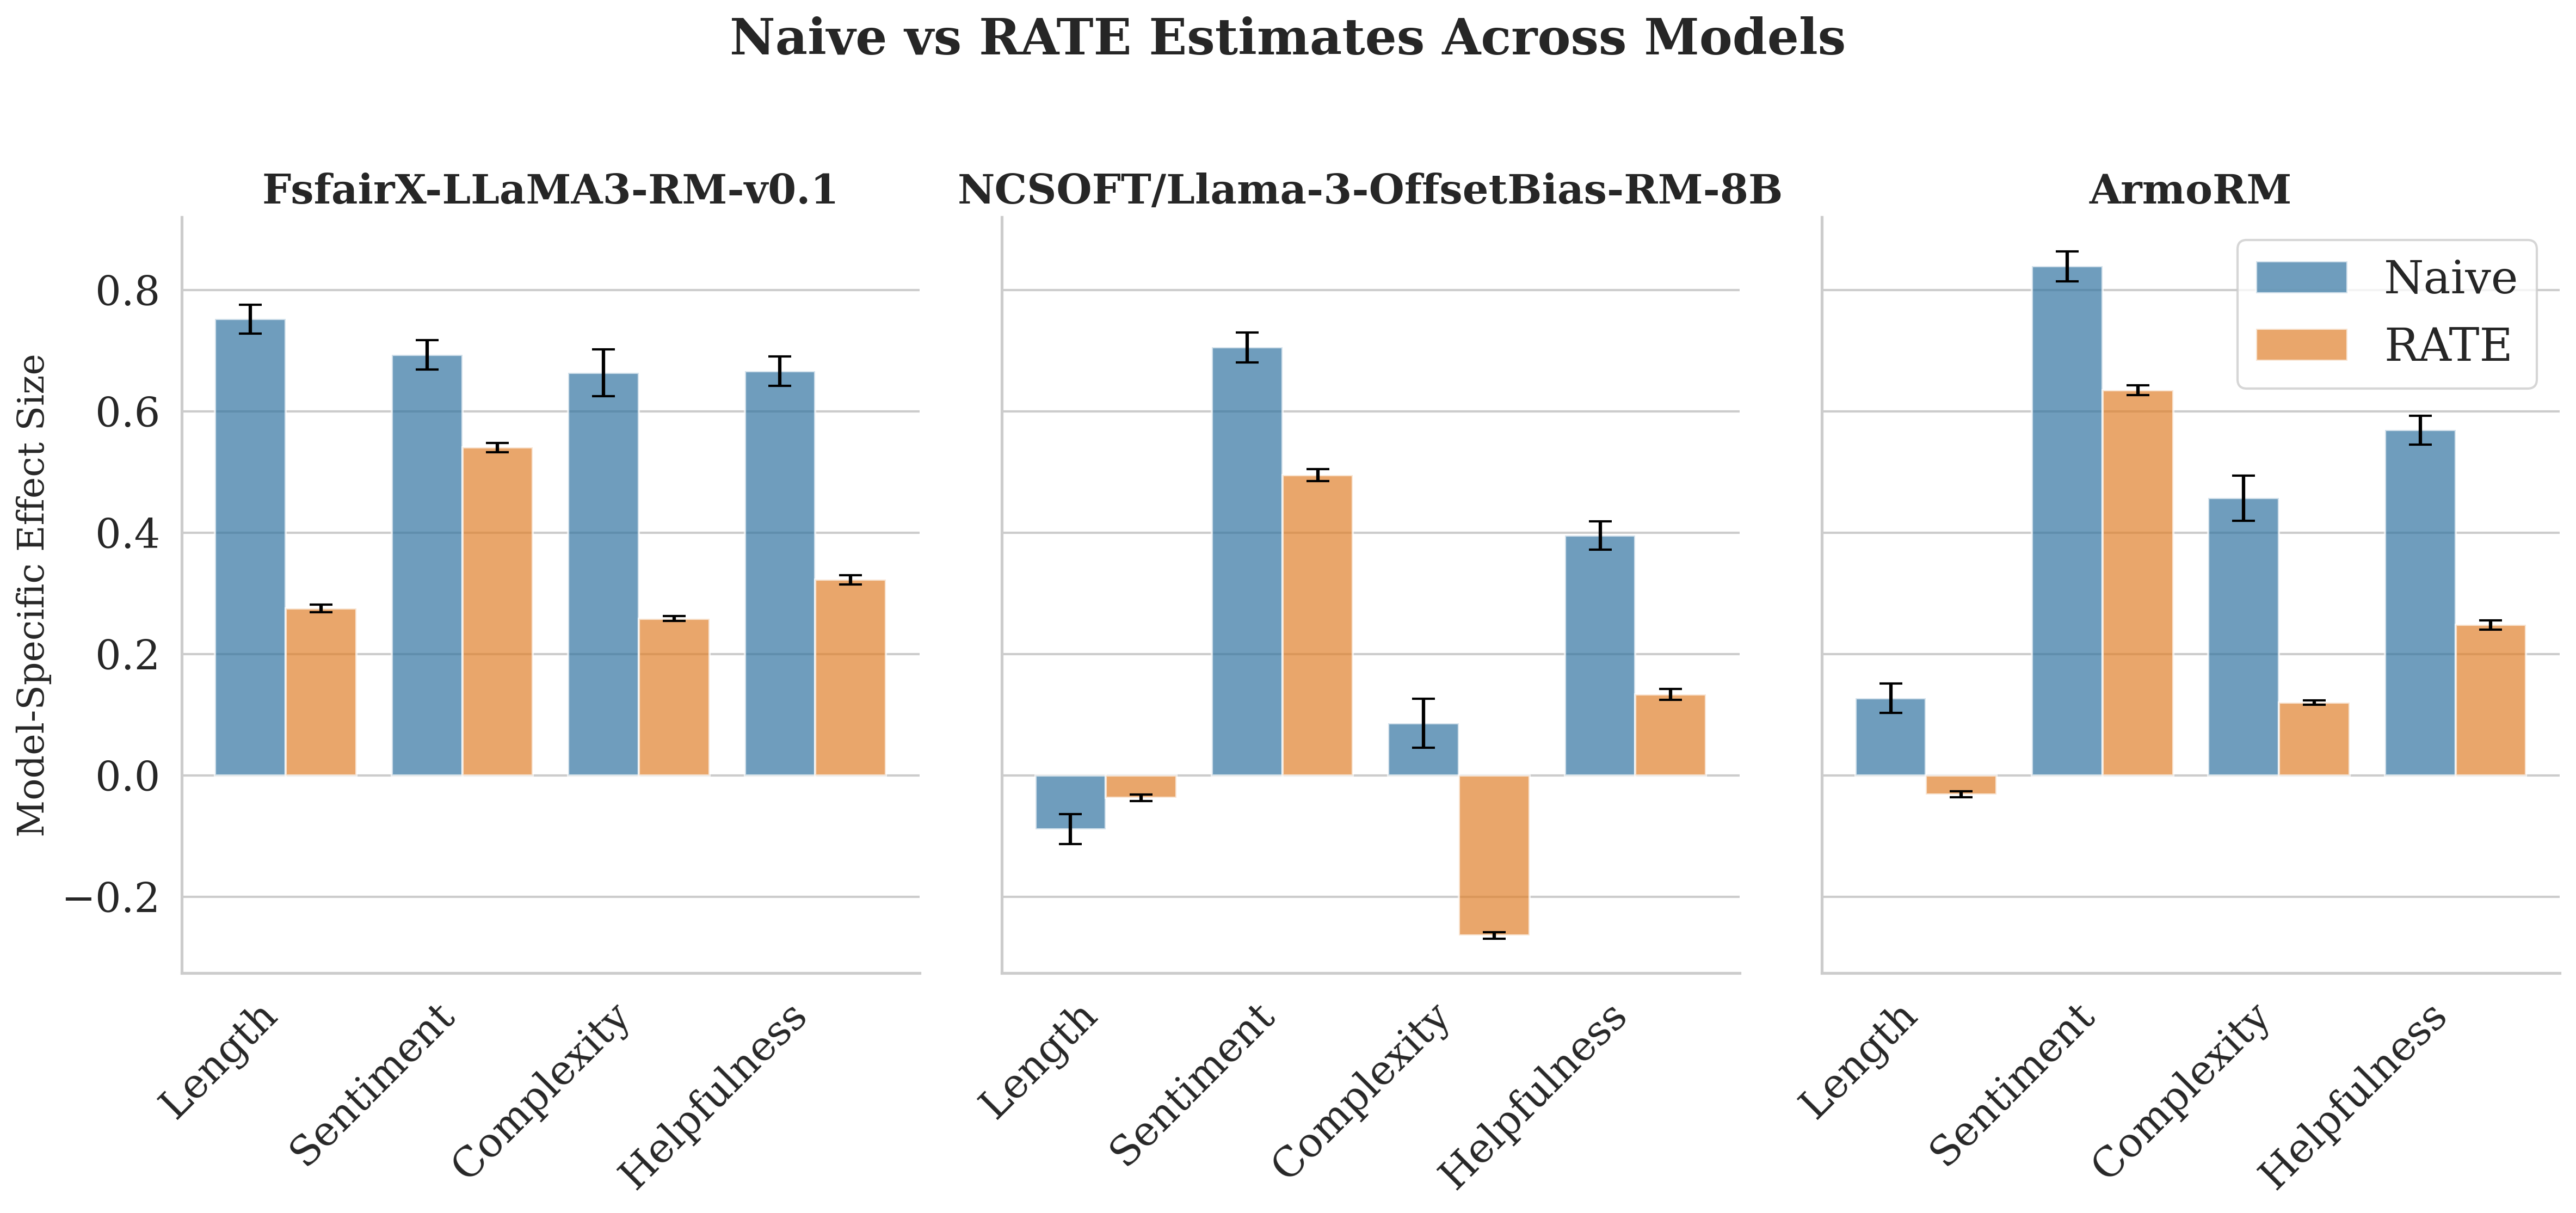

In [10]:
reward_models = ['FsfairX-LLaMA3-RM-v0.1', 'NCSOFT/Llama-3-OffsetBias-RM-8B', 'ArmoRM']
naive_vs_RATE(effects_data, experiment_templates, reward_models, normalize = 'reward_std')

Next we compare the RATE ATT vs ATU estimates for a particular tuple, also normalized.

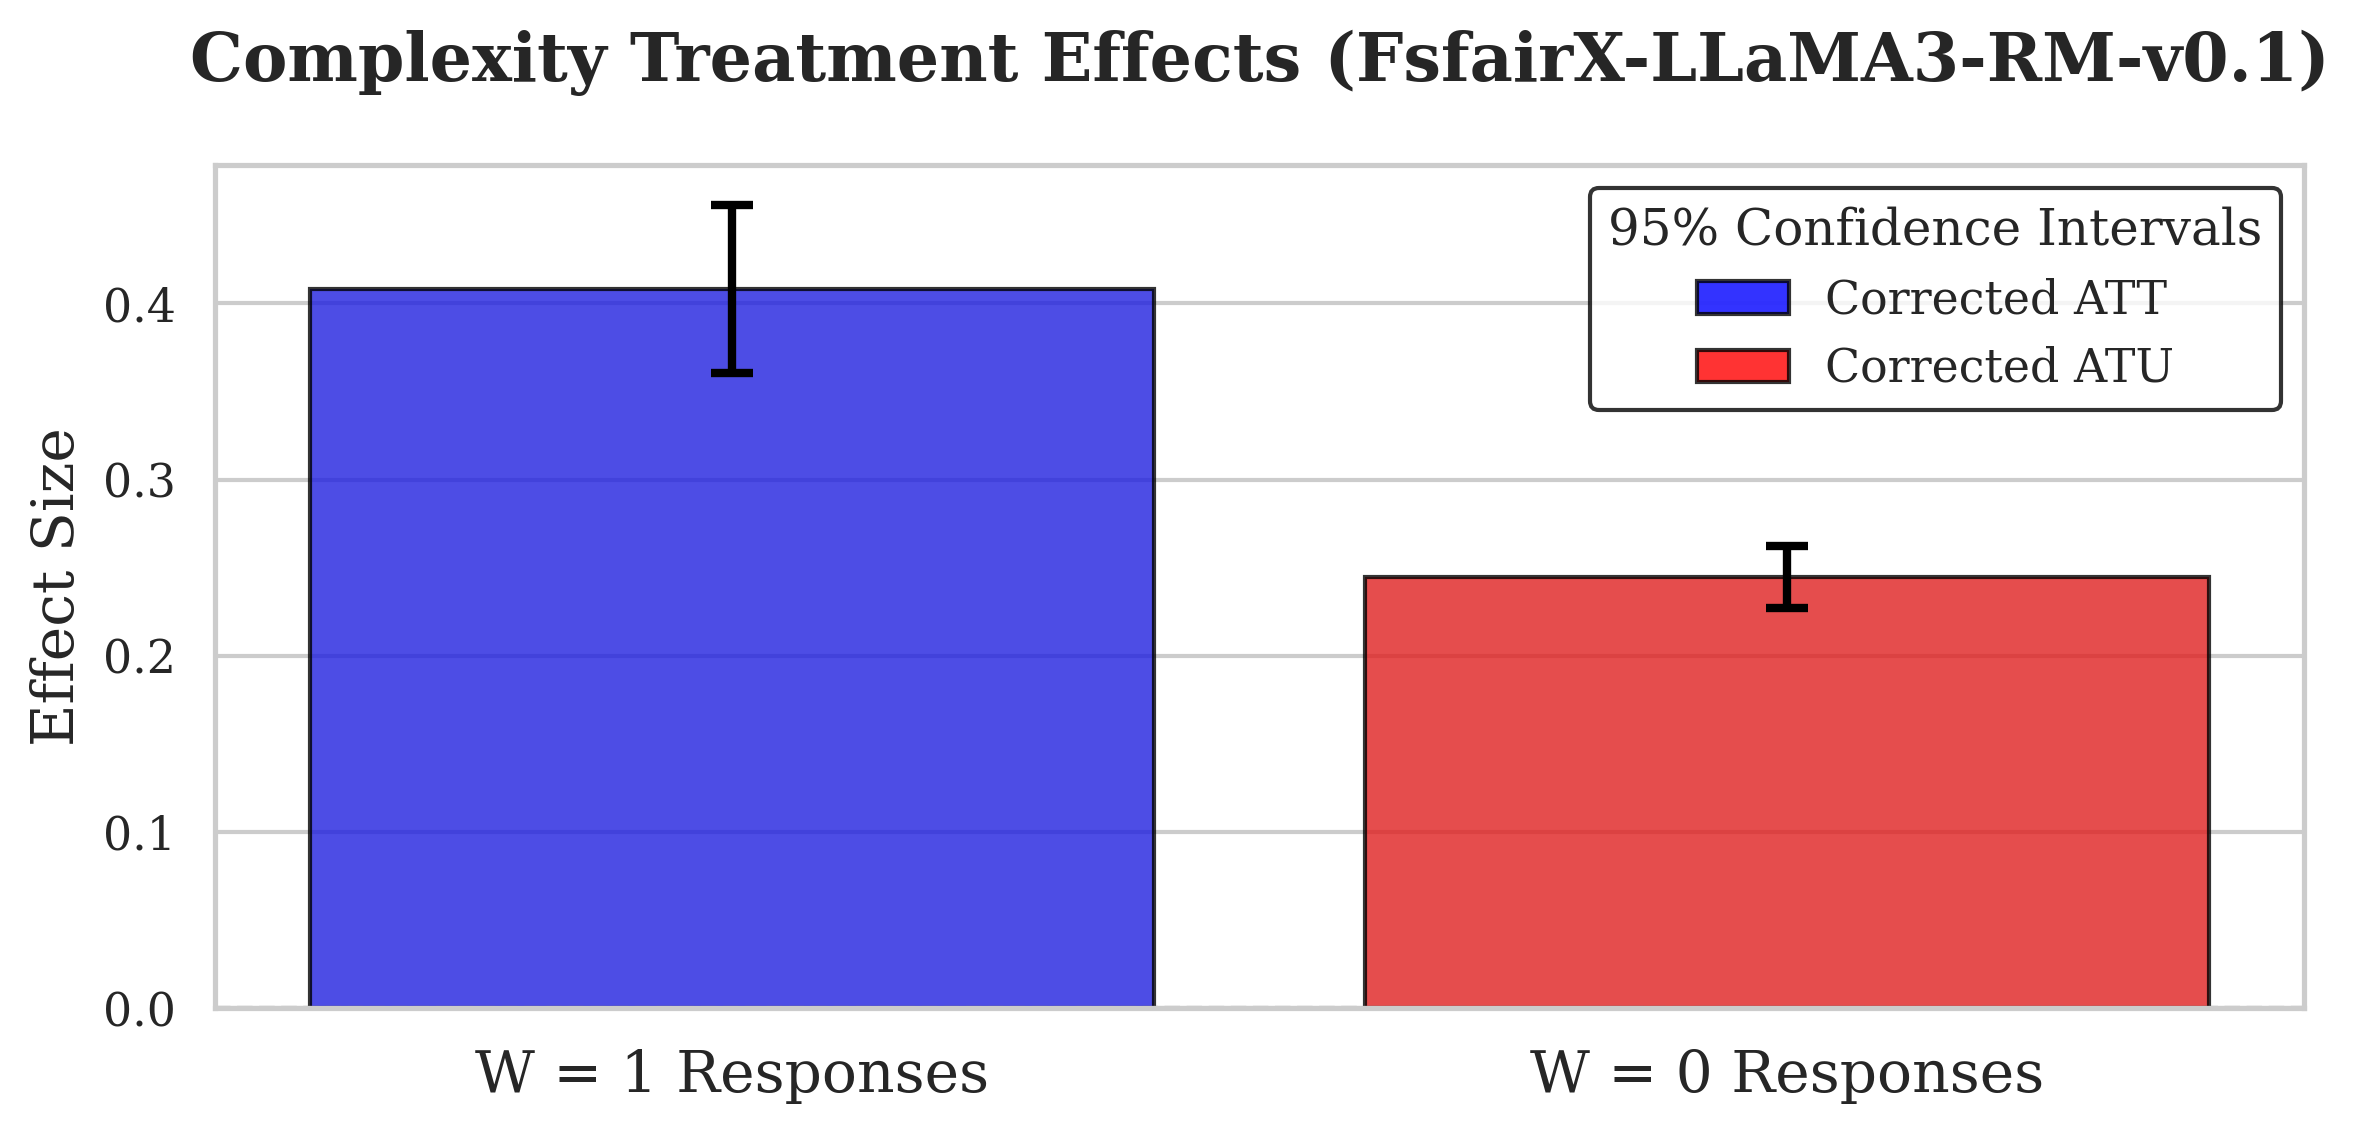

In [11]:
att_atu(effects_data[8], effects_data[8]['reward_std'])

We do a similar thing for the synthetic data.

In [13]:
synthetic_templates = [
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_0.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_1.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_2.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_3.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_4.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_5.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_6.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_7.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_8.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_9.jsonl"
    },
    {
        "dataset_name": "IMDB",
        "concept": "Length",
        "score": "DistilBERT",
        "reward_key": "distilbert-base-uncased-finetuned-sst-2-english_positive_logit",
        "dataset_filename": "imdb_length_negative_logit_scored_20240917_184415_correlated_10.jsonl"
    }
]

In [14]:
# save all the data
synthetic_data = []
for effects_template in synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic" / "positive_long" / dataset_filename)
    effects = calculate_treatment_effects(dataset, **effects_template)
    synthetic_data.append(effects)

2024-10-02 00:08:39,227 - INFO - Number of w=1 examples: 4004
2024-10-02 00:08:39,228 - INFO - Number of w=0 examples: 5372
2024-10-02 00:08:39,251 - INFO - Treatment effects: {   'ATE': 0.0844035465969567,
    'ATE_naive': 0.16884899790376523,
    'ATE_stderr': 0.008534547037940212,
    'ATE_stderr_naive': 0.01354892736882799,
    'ATT': 0.2384955123230651,
    'ATT_naive': -0.330754465871043,
    'ATT_stderr': 0.06947906261246611,
    'ATT_stderr_naive': 0.0658152432122367,
    'ATU': -0.0304483206344911,
    'ATU_naive': 0.5412265610002531,
    'ATU_stderr': 0.0685568950220651,
    'ATU_stderr_naive': 0.06504727320061249,
    'naive_effect': -0.25964819403447226,
    'naive_effect_naive': -0.2572232905938362,
    'naive_effect_stderr': 0.07015354089099915,
    'naive_effect_stderr_naive': 0.06290409599455854}
2024-10-02 00:08:39,252 - INFO - Calculated ATE (from ATT and ATU): 0.08440354659695674
2024-10-02 00:08:39,258 - INFO - Rewrite effects: {   'rewrite_effect_w_0': 0.5716748816

In [17]:
help_synthetic_templates = [
    {
        "dataset_name": "HelpSteer",
        "concept": "Helpfulness",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": f"synthetic_helpsteer_base_correlated_{i}.jsonl"
    } for i in range(11)
    ]

In [18]:
# save all the data
help_synthetic_data = []
for effects_template in help_synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic_helpsteer" / dataset_filename)
    effects = calculate_treatment_effects(dataset, **effects_template)
    help_synthetic_data.append(effects)

2024-10-02 00:08:43,387 - INFO - Number of w=1 examples: 2574
2024-10-02 00:08:43,388 - INFO - Number of w=0 examples: 2574
2024-10-02 00:08:43,410 - INFO - Treatment effects: {   'ATE': 0.014393984818637143,
    'ATE_naive': 0.01957111698185457,
    'ATE_stderr': 0.0003646353423113441,
    'ATE_stderr_naive': 0.0005043422673346951,
    'ATT': 0.0054083771461102825,
    'ATT_naive': 0.04116395636899113,
    'ATT_stderr': 0.0011309362696518663,
    'ATT_stderr_naive': 0.0009968333851053208,
    'ATU': 0.02337959249116403,
    'ATU_naive': -0.002021722405281992,
    'ATU_stderr': 0.0010911649065769267,
    'ATU_stderr_naive': 0.001127463717047579,
    'naive_effect': 0.02154123385671293,
    'naive_effect_naive': 0.031895498183147755,
    'naive_effect_stderr': 0.0010809832609582038,
    'naive_effect_stderr_naive': 0.000981691571743384}
2024-10-02 00:08:43,411 - INFO - Calculated ATE (from ATT and ATU): 0.014393984818637157
2024-10-02 00:08:43,415 - INFO - Rewrite effects: {   'rewrite_

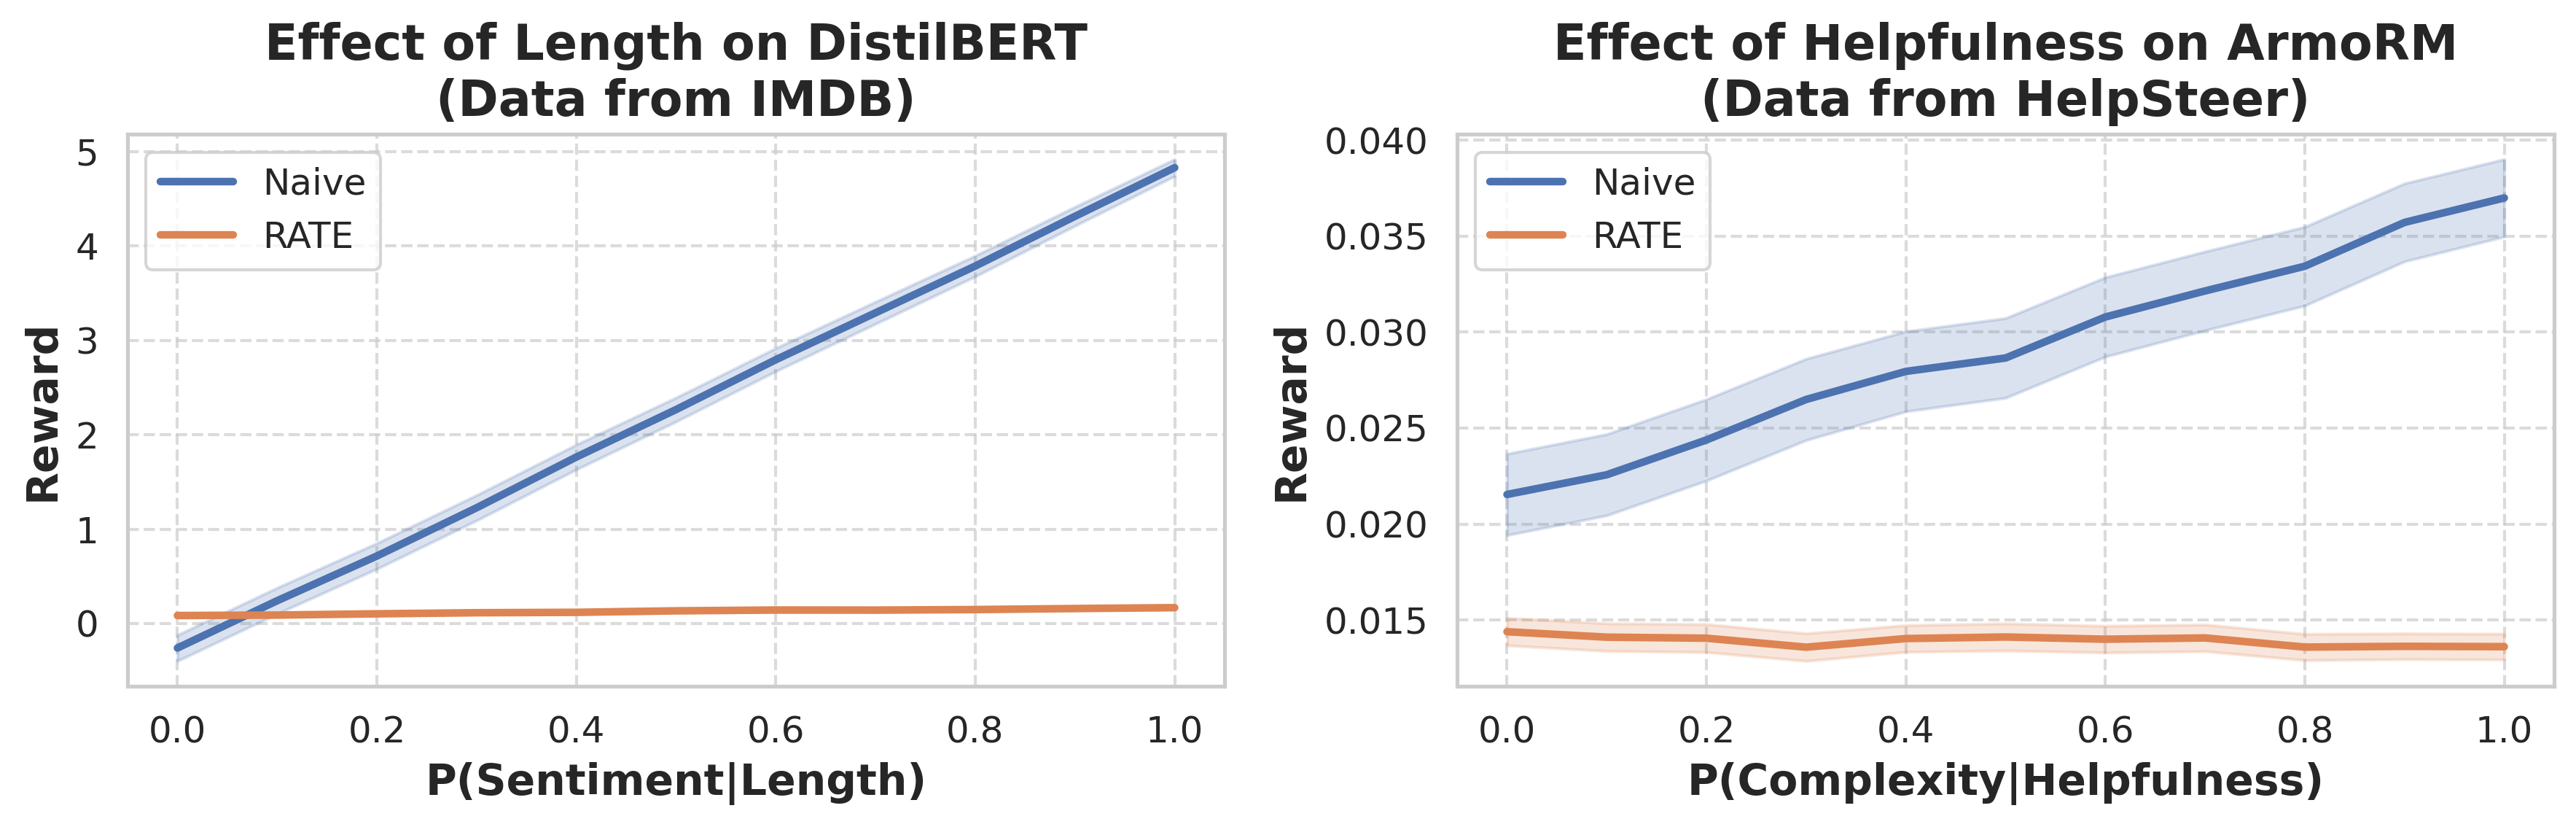

In [19]:
synthetic_subplots(synthetic_data, synthetic_templates, "Length", "Sentiment",
          help_synthetic_data, help_synthetic_templates, "Helpfulness", "Complexity")